# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [72]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [73]:
churn_data = pd.read_csv('../../data/churn_ML_3.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

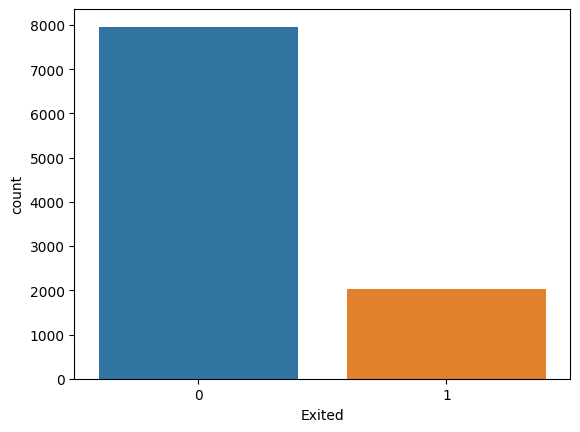

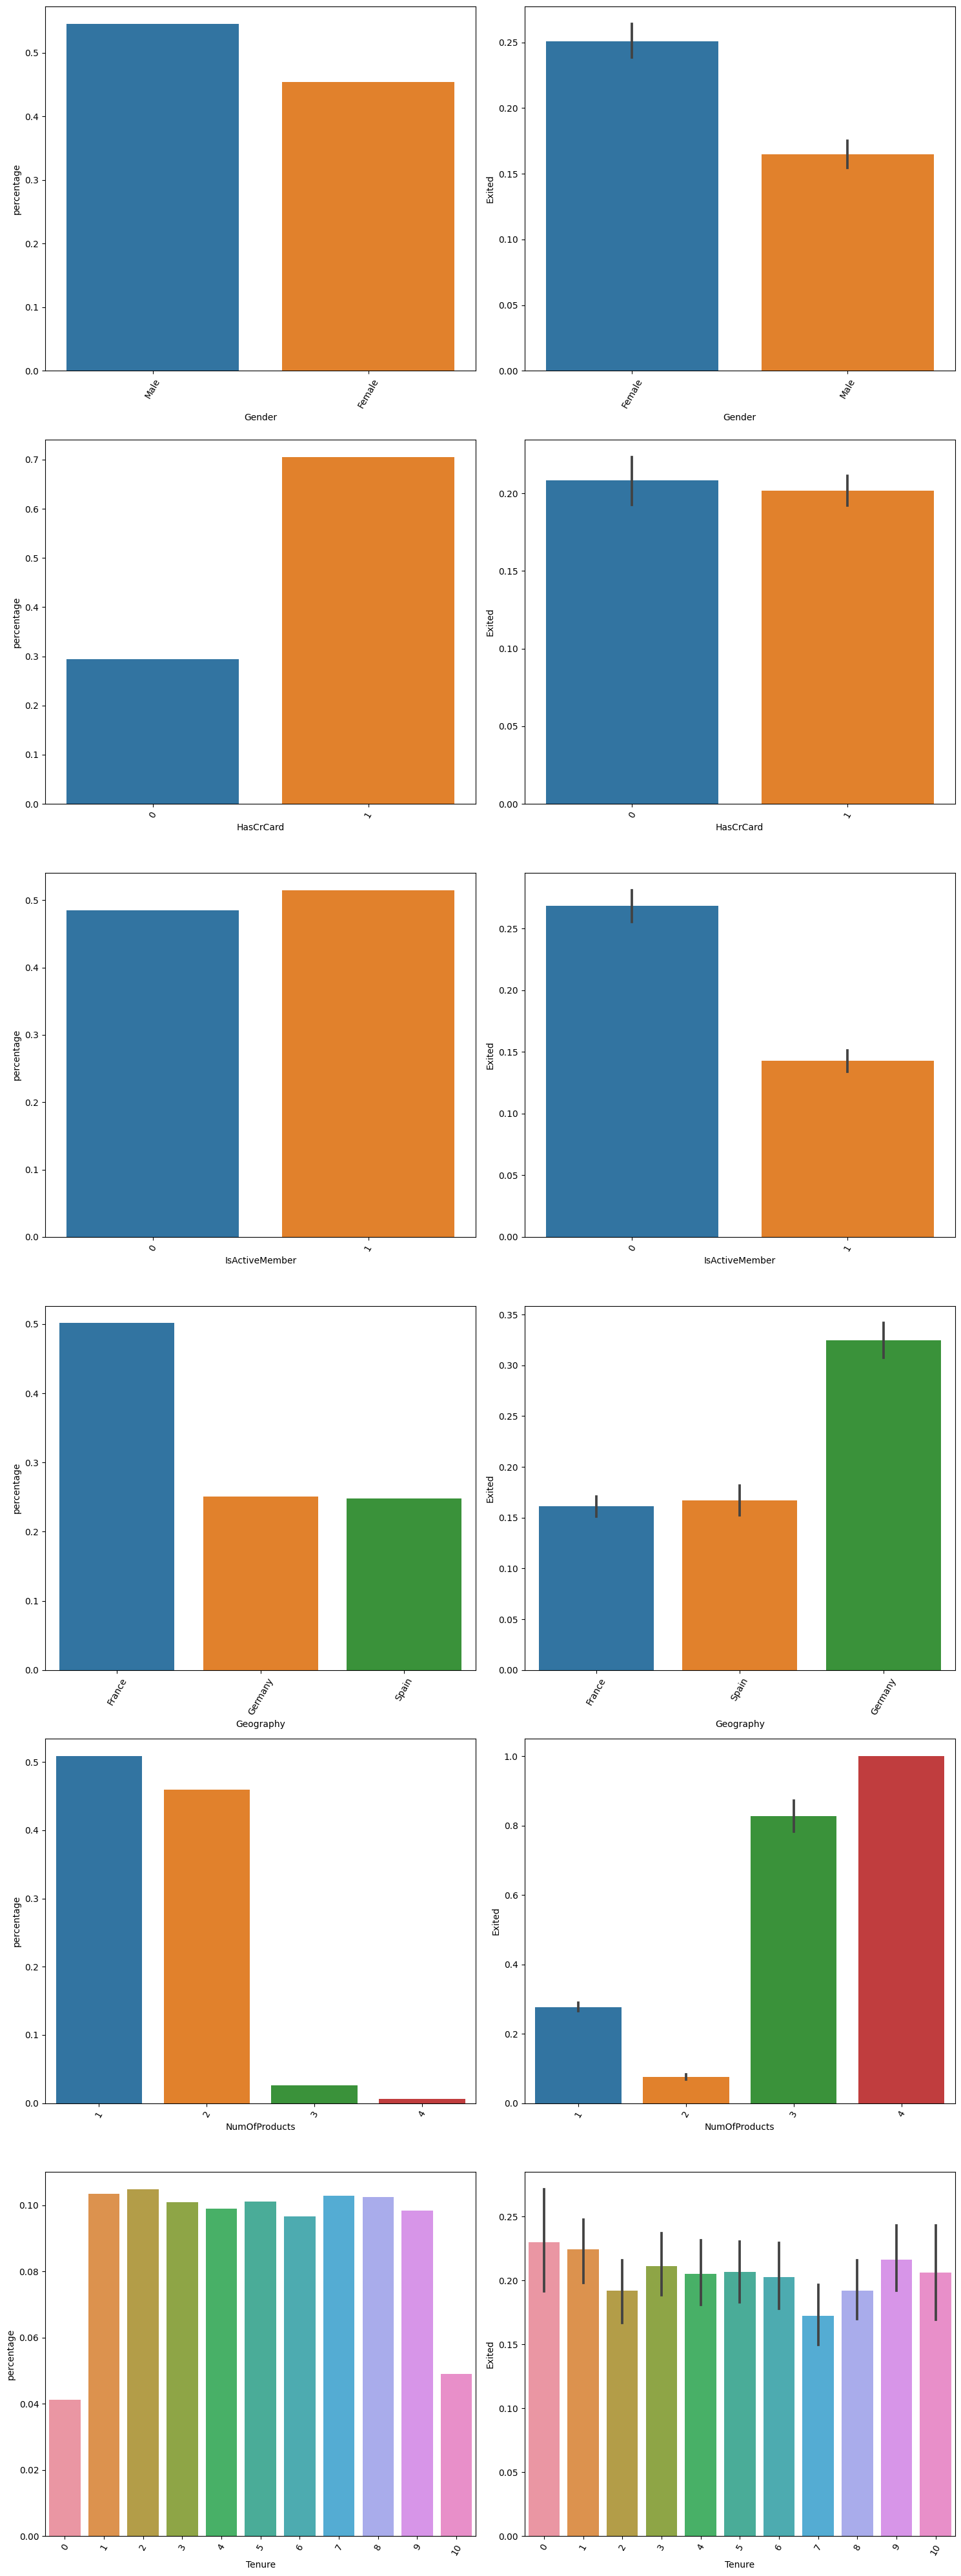

In [74]:
# копируем данные
temp_data=churn_data.copy()

sns.countplot(data=temp_data, x='Exited');

#Создаём список признаков с чем можем сравнить без обработки
temp_list = list(temp_data.drop('Exited',axis=1).nunique().sort_values().head(6).index)


n = len(temp_list) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
# #Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(temp_list):
    #Строем количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (temp_data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    # display(count_data)
    count_barplot = sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строем столбчатую диаграмму доли людей ушедших клиентов в зависимости от категории
    mean_barplot = sns.barplot(data=temp_data, x=feature, y='Exited', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [75]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [76]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [77]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [78]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

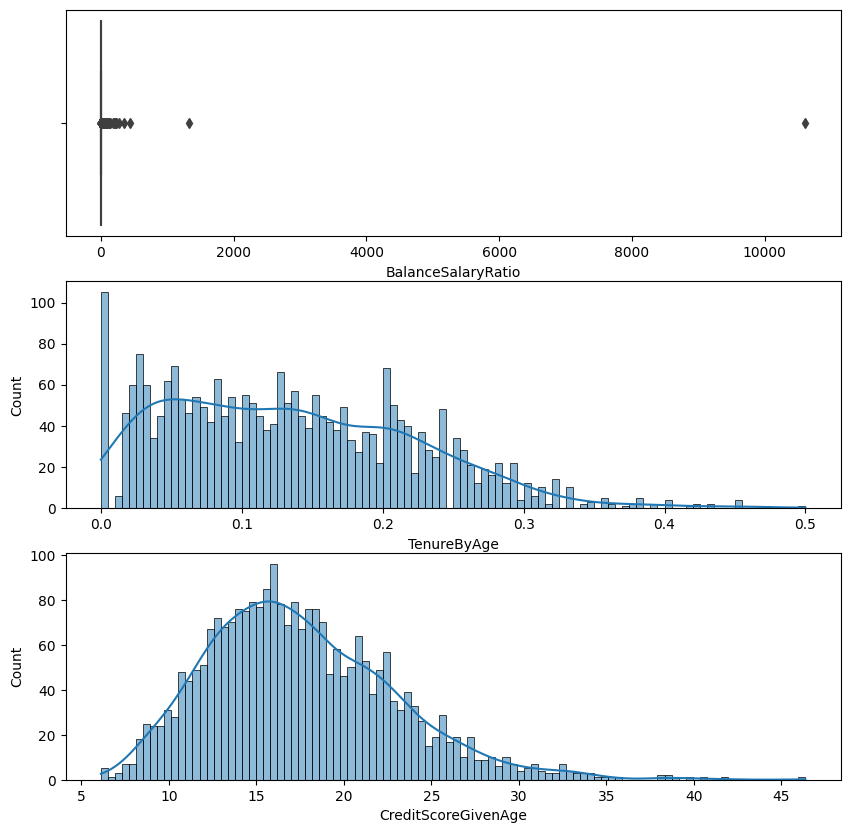

In [79]:
# Список признаков для создания новых признаков
temp_list=['Balance','EstimatedSalary','Tenure','Age','CreditScore','Age']
new_list=['BalanceSalaryRatio','TenureByAge','CreditScoreGivenAge']
# Создаем новые признаки
for i in range(len(new_list)):
    churn_data[new_list[i]]=churn_data[temp_list[i*2]]/churn_data[temp_list[i*2+1]]

# Удаляем старые признаки
churn_data=churn_data.drop(set(temp_list), axis=1)

# Кодируем признак Гендор
churn_data['Gender']=churn_data['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Выводим грфики с полученными признаками
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
sns.boxplot(
    data=churn_data, x='BalanceSalaryRatio', orient='h',
    width=0.9, ax=axes[0]);
sns.histplot(
    data=churn_data, x='TenureByAge', bins=100,
    kde=True, ax=axes[1]);
sns.histplot(
    data=churn_data, x='CreditScoreGivenAge', bins=100,
    kde=True, ax=axes[2]);

# Данные не нормальны

Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [80]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [81]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [82]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 7)
Test shape: (628, 7)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [83]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [84]:
# StandardScaler подходит для нормально распределённых данных. Он сохраняет исходное распределение и не меняет форму, но чувствителен к выбросам и не подходит для данных с негауссовским распределением. 1
# MinMaxScaler масштабирует признаки в заданный диапазон, сохраняя взаимосвязи. Он не искажает исходное распределение, но чувствителен к выбросам и не эффективно обрабатывает данные с крайними выбросами. 1
# RobustScaler эффективно работает с данными с выбросами. 14 Для масштабирования он использует медиану и межквартильный диапазон, что позволяет обрабатывать признаки с большим количеством выбросов без влияния на них.
# Так как имеются выбросы применим RobustScaler
scaler = preprocessing.RobustScaler()
# scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
display(scaler)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Параметры выборки после трансформации')
X_train_scaled

RobustScaler()

Параметры выборки после трансформации


array([[ 0.        ,  0.        ,  0.        , ...,  0.03507576,
        -0.55780477, -0.42250305],
       [-1.        ,  1.        ,  0.        , ...,  0.55107329,
         1.04090354,  0.86249751],
       [ 0.        ,  0.        , -1.        , ..., -0.30600356,
         0.52991453,  3.4693599 ],
       ...,
       [-1.        ,  1.        ,  0.        , ..., -0.28690426,
        -0.15545962, -0.76741602],
       [-1.        ,  0.        , -1.        , ...,  0.39205406,
         0.31903018,  0.08293689],
       [-1.        ,  0.        ,  0.        , ...,  1.46954065,
        -0.59480202,  2.57170966]])

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Укажите название метрики и обоснования своего выбора здесь

    Выберим PRECISION метрику.
    Так как в задании сказано что:
    1. Будим работать с клиентами у которых вероятность оттока наиболее высока
        + PRECISION: Используется в задачах, где важно минимальное количество ложноположительных срабатываний модели
    2. Ресурсы, выделяемые на сохранение клиентов, ограничены
        + по этому надо мимимезировать ложно полажительных клиентов
    3. Однако в то же время необходимо сохранить как можно больше клиентов
        + Надо провести Моделирование + оценка модели чтоб определится с порогом вероятности

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Ваши рассуждения и ответ — *здесь*.

    Чтобы решить нашу задачу, нам нужно выбрать модель, которая будет давать меньше ложных срабатываний. Поскольку ресурсы, выделяемые на сохранение клиентов, ограничены, нам крайне важно минимизировать количество совершаемых звонков.

    PRECISION модель — это метод, который позволяет четко разделить классы на положительные и отрицательные. Она используется в задачах, где требуется минимизировать количество ложных срабатываний модели.

    Мы выбрали PRECISION, потому что она не будет давать ложноположительных результатов. Это позволит нам минимизировать ресурсы банка, выделяемые на сохранение клиентов, а также сократить количество звонков и уменьшить нагрузку на кол-центр. Также мы будем анализировать метод F1, REAL и искать наилучший порог вероятности PRECISION и RECALL.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [85]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
        # solver='sag', #алгоритм оптимизации
        random_state=42, #генератор случайных чисел 
        penalty='l2', 
        C=1.5
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1271
           1       0.65      0.41      0.51       610

    accuracy                           0.74      1881
   macro avg       0.71      0.65      0.66      1881
weighted avg       0.73      0.74      0.72      1881

              precision    recall  f1-score   support

           0       0.74      0.88      0.80       424
           1       0.58      0.34      0.43       204

    accuracy                           0.71       628
   macro avg       0.66      0.61      0.62       628
weighted avg       0.68      0.71      0.68       628



> Ваши выводы и рассуждения — *здесь*.

    Модель можно считать, удовлетворительной так как значение целевой метрики на тестовой выборке больше 0.5,
    но модель с большей точностью предсказывает лояльных клиентов 

+ penalty='l1' выдает ошибку "Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty" чтобы не было ошибки надо указать параметр "solver='liblinear'"
+ penalty='l2' на метрику не  влияет
+ C 0.6-1.5 не даёт прирост в метрики

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [86]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)#degree=2,
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print('{} равно результирующее количество столбцов'.format(X_train_poly.shape[1]))

#Создаем объект класса логистическая регрессия
log_reg_poly = linear_model.LogisticRegression(
        # solver='sag', #алгоритм оптимизации
        random_state=42, #генератор случайных чисел 
        # max_iter=1000,
        # solver='liblinear',
        penalty='l2', 
        # C=1
)

#Обучаем модель, минимизируя logloss
log_reg_poly.fit(X_train_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg_poly.predict(X_train_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg_poly.predict(X_test_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

119 равно результирующее количество столбцов
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      1271
           1       1.00      0.00      0.01       610

    accuracy                           0.68      1881
   macro avg       0.84      0.50      0.41      1881
weighted avg       0.78      0.68      0.55      1881

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       424
           1       0.67      0.01      0.02       204

    accuracy                           0.68       628
   macro avg       0.67      0.50      0.41       628
weighted avg       0.67      0.68      0.55       628



> Ваши выводы и рассуждения — *здесь*
1. Мы сгенерировали полиномиальные признаки третьей степени, что позволило нам получить 119 признаков.

2. В результате мы создали улучшенную модель, которая, как нам кажется, может быть переобучена. На тренировочной выборке она демонстрирует отличные результаты, а на тестовой — удовлетворительные. Однако, поскольку точность не выходит за пределы 0,5, мы полагаем, что переобучение отсутствует, и модель работает хорошо.

3. Коэффициент С, равный 1.0, позволяет оптимизировать модель логистической регрессии.


### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Результат тренировочной выборки полученными ранее 1.00
Текущий результат тренировочной выборки 0.58
Результат тестовой выборки полученными ранее 0.67
Текущий результат тестовой выборки 0.52


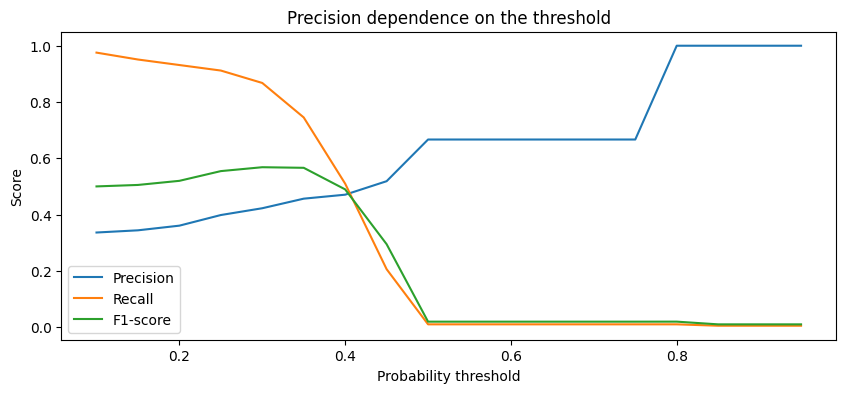

In [87]:
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg_poly.predict_proba(X_test_poly)[:, 1]
y_train_proba_pred = log_reg_poly.predict_proba(X_train_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
y_train_proba_pred = pd.Series(y_train_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
precision_scores = []
recall_scores=[]
f1_scores=[]

#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    precision_scores.append(metrics.precision_score(y_test, y_test_pred_poly))
    recall_scores.append(metrics.recall_score(y_test, y_test_pred_poly))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred_poly))
    
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, f1_scores, label='F1-score')

#Даем графику название и подписи осям
ax.set_title('Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

#Задаем оптимальный порог вероятностей
threshold_opt = 0.45
#Людей, у которых вероятность ухода из банка больше 0.8 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
y_train_pred_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print('Результат тренировочной выборки полученный ранее {:.2f}'.format(metrics.precision_score(y_train, y_train_pred)))
print('Текущий результат тренировочной выборки {:.2f}'.format(metrics.precision_score(y_train, y_train_pred_opt)))
print('Результат тестовой выборки полученный ранее {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Текущий результат тестовой выборки {:.2f}'.format(metrics.precision_score(y_test, y_test_pred_opt)))

> Ваши выводы и рассуждения — *здесь*
* значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики = 0.8
* оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке = 0.45
* Значения на тестовой выборке у нас больше 0.5 считаем что модель работает удовлитворительно
    + Также можно отметить что модель соответствует тех заданию (в нашу выборку будут попадать клиенты у которых вероятность оттока наиболее высока и им будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов ограничены, поэтому нам важно минимизировать количество звонков)
    

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [88]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 7)
Test shape: (628, 7)


Импортируем необходимые для выполнения практики модули:

In [89]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [90]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_2d = tree.DecisionTreeClassifier(
    max_depth=None, # максимальная глубина дерева
    criterion='entropy',  
    random_state=42)

#Обучаем дерево решений по алгоритму CART
dt_clf_2d.fit(X_train, y_train)

#Делаем предсказание класса для всего набора данных
y_train_pred = dt_clf_2d.predict(X_train)
y_test_pred = dt_clf_2d.predict(X_test)
#Выводим отчёт о метриках классификации
print('Тренировочная выборка')
print(metrics.classification_report(y_train, y_train_pred))
print('Тестовоя выборка')
print(metrics.classification_report(y_test, y_test_pred))

Тренировочная выборк
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      1.00      1.00       610

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881

Тестовоя выборк
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       424
           1       0.51      0.52      0.52       204

    accuracy                           0.68       628
   macro avg       0.64      0.64      0.64       628
weighted avg       0.68      0.68      0.68       628



> Ваши выводы и рассуждения — *здесь*

Модель оказалась переобученной. Это видно по результатам её работы: на тренировочном наборе данных она демонстрирует 1,0, а на тестовом — почти в два раза меньше, 0,51. Это говорит о том, что модель не способна предсказывать данные, с которыми она не сталкивалась ранее.

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [91]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_2d = tree.DecisionTreeClassifier(
    max_depth=8, #максимальная глубина дерева
    criterion='entropy', 
    min_samples_leaf= 10, # минимальное число объектов в листе
    random_state=42)

#Обучаем дерево решений по алгоритму CART
dt_clf_2d.fit(X_train, y_train)

#Делаем предсказание класса для всего набора данных
y_train_pred = dt_clf_2d.predict(X_train)
y_test_pred = dt_clf_2d.predict(X_test)
#Выводим отчёт о метриках классификации
print('Тренировочная выборка')
print(metrics.classification_report(y_train, y_train_pred))
print('Тестовоя выборка')
print(metrics.classification_report(y_test, y_test_pred))

Тренировочная выборк
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1271
           1       0.79      0.64      0.71       610

    accuracy                           0.83      1881
   macro avg       0.82      0.78      0.79      1881
weighted avg       0.82      0.83      0.82      1881

Тестовоя выборк
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       424
           1       0.66      0.50      0.57       204

    accuracy                           0.75       628
   macro avg       0.72      0.69      0.70       628
weighted avg       0.74      0.75      0.74       628



> Ваши выводы и рассуждения — *здесь*

Модель стала более устойчивой к переобучению благодаря ограничению глубины дерева. В результате на тестовой выборке были достигнуты более высокие результаты, чем у предыдущей модели и логистической регрессии.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [92]:
#Создаём объект класса DecisionTreeClassifier
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    max_depth=8, # максимальная глубина дерева
    criterion='entropy',
    min_samples_leaf= 10, # минимальное число объектов в листе  
    random_state=42)

#Обучаем дерево решений по алгоритму CART
rf_clf_2d.fit(X_train, y_train)

#Делаем предсказание класса для всего набора данных
y_train_pred = rf_clf_2d.predict(X_train)
y_test_pred = rf_clf_2d.predict(X_test)
#Выводим отчёт о метриках классификации
print('Тренировочная выборка')
print(metrics.classification_report(y_train, y_train_pred))
print('Тестовоя выборка')
print(metrics.classification_report(y_test, y_test_pred))

Тренировочная выборк
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1271
           1       0.80      0.60      0.68       610

    accuracy                           0.82      1881
   macro avg       0.81      0.76      0.78      1881
weighted avg       0.82      0.82      0.81      1881

Тестовоя выборк
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       424
           1       0.68      0.50      0.57       204

    accuracy                           0.76       628
   macro avg       0.73      0.69      0.70       628
weighted avg       0.75      0.76      0.75       628



> Ваши выводы и рассуждения — *здесь*

Благодаря использованию случайного леса деревьев, модель стала более стабильной, и мы добились повышения результатов на тестовой выборке.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

c:\Users\Temnykov\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Temnykov\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Результат тренировочной выборки полученными ранее 0.80
Текущий результат тренировочной выборки 0.75
Результат тестовой выборки полученными ранее 0.68
Текущий результат тестовой выборки 0.65


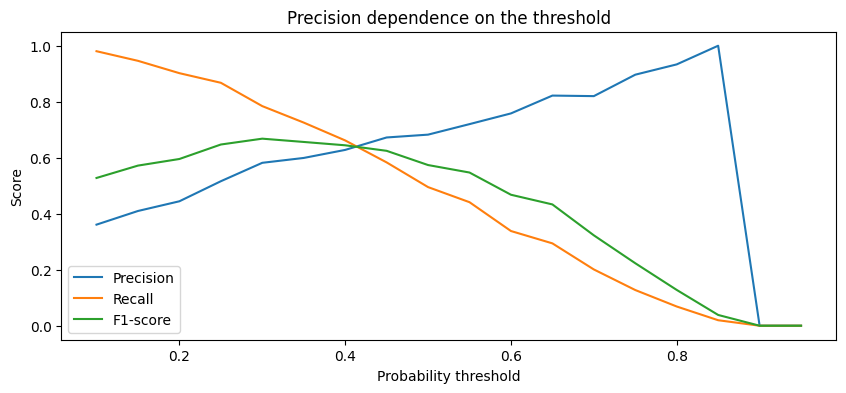

In [93]:
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf_clf_2d.predict_proba(X_test)[:, 1]
y_train_proba_pred = rf_clf_2d.predict_proba(X_train)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
y_train_proba_pred = pd.Series(y_train_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
precision_scores = []
recall_scores=[]
f1_scores=[]

#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    precision_scores.append(metrics.precision_score(y_test, y_test_pred_poly))
    recall_scores.append(metrics.recall_score(y_test, y_test_pred_poly))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred_poly))
    
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, f1_scores, label='F1-score')

#Даем графику название и подписи осям
ax.set_title('Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

#Задаем оптимальный порог вероятностей
threshold_opt = 0.43
#Людей, у которых вероятность ухода из банка больше 0.8 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
y_train_pred_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print('Результат тренировочной выборки полученными ранее {:.2f}'.format(metrics.precision_score(y_train, y_train_pred)))
print('Текущий результат тренировочной выборки {:.2f}'.format(metrics.precision_score(y_train, y_train_pred_opt)))
print('Результат тестовой выборки полученными ранее {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Текущий результат тестовой выборки {:.2f}'.format(metrics.precision_score(y_test, y_test_pred_opt)))

> Ваши выводы и рассуждения — *здесь*

На графике мы видим, что показатели Precision, Recall и F1 пересекаются в точке 0.45. Это означает, что в данной точке достигается баланс между Precision и Recall. Значение Precision составляет 0.65, что свидетельствует о высокой эффективности работы модели.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [95]:
x_new = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

# Список признаков для создание новых признаков
temp_list=['Balance','EstimatedSalary','Tenure','Age','CreditScore','Age']
new_list=['BalanceSalaryRatio','TenureByAge','CreditScoreGivenAge']
# Создаем новые признаки
for i in range(len(new_list)):
    x_new[new_list[i]]=x_new[temp_list[i*2]]/x_new[temp_list[i*2+1]]

# Удаляем старые признаки
x_new=x_new.drop(set(temp_list), axis=1)

# Кодируем признак Гендор
x_new['Gender']=x_new['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

#Делаем предсказание вероятностей:
x_new_scaled = scaler.transform(x_new)
y_new_proba_predict = log_reg.predict_proba(x_new_scaled)[:,1]
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 3)))

#Делаем предсказание вероятностей:
x_new_poly = poly.transform(x_new_scaled)
y_new_proba_predict = log_reg_poly.predict_proba(x_new_poly)[:,1]
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 3)), '+ смешение 0,45')

#Делаем предсказание вероятностей:
y_new_proba_predict = dt_clf_2d.predict_proba(x_new)[:,1]
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 3)))

#Делаем предсказание вероятностей:
y_new_proba_predict = rf_clf_2d.predict_proba(x_new)[:,1]
print('Наилучшая модель')
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 3)))

Predicted probabilities: [0.523]
Predicted probabilities: [0.5] + смешение 0,45
Predicted probabilities: [0.714]
Наилучшая модель
Predicted probabilities: [0.722]


c:\Users\Temnykov\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


* Я обработал данные Василия с помощью всех наших моделей, чтобы узнать, какие результаты они дадут.

* Линейные регрессии показали неоднозначные результаты по Василию. Однако деревья дали более точный прогноз.

* Наилучшая модель предсказывает, что с вероятностью 0,722 Василий покинет банк.